In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using DSP

using ImageFiltering

In [2]:
function cv_constructor(histogram::Histogram; α::Int64=2, n_max::Int64 = 6000)
    
    background_values = histogram.weights
    edges = histogram.edges[1]
    cv_matrix = zeros(Float64, 4096, n_max)
    
    # replace bins with 0 counts
    mask_b = iszero.(background_values)
    non_zero_min = minimum(background_values[.!mask_b])
    background_values[mask_b] .= non_zero_min
    
#     kern_background = KernelFactors.gaussian(3)
#     background_values= imfilter(background_values, kern_background)
    # ***

    # if the signal prediction == 0, then we use only background distribution
    cv_matrix[:,1] .= background_values 
    
    for i in 2:n_max
        signal_vals = cdf.(truncated(Normal(i-1, α*sqrt(i-1)), edges[1], edges[end]), edges)
        signal_vals = diff(signal_vals)
        
        # signal_vals = pdf.(Normal(i-1, α*sqrt(i-1)), h_bins)
        signal_conv = DSP.conv(signal_vals, background_values)[1:4096]
        signal_conv = abs.(signal_conv)
        
        mask = iszero.(signal_conv) # if convolution returns zero - replace it with minimum value 
        min_non_zero = minimum(signal_conv[.!mask])
        
        signal_conv[mask] .= min_non_zero
        
        if sum(signal_conv) < 0 
            signal_conv[end] += 1 - sum(signal_conv)
        elseif sum(signal_conv) > 0 
            signal_conv = signal_conv ./ sum(signal_conv)
        end
        
        cv_matrix[:,i] .= signal_conv 
    end
    
    # Apply convolution filter: 
    kern = KernelFactors.gaussian((3, 3))
    cv_matrix = imfilter(cv_matrix, kern)
    
    for i in 1:n_max
        cv_matrix[:,i] .= cv_matrix[:,i] ./ sum(cv_matrix[:,i]) 
    end
    # Coment out if not needed 
    
    return cv_matrix
end

function pixel_probability(predicted_value::Int64, observed_value::Int64, conv_matrix::Array{Float64,2})
    
    predicted_ind::Int64 = predicted_value + 1
    observed_ind::Int64 = observed_value + 1
    
    return conv_matrix[observed_ind, predicted_ind]
end

pixel_probability (generic function with 1 method)

In [3]:
background_hist_1 = load("../data/experiment/dataset_2/m1/background.jld2")
background_hist_2 = load("../data/experiment/dataset_2/m2/background.jld2")

cv_1_1 = cv_constructor(background_hist_1["cam_1"])
cv_1_2 = cv_constructor(background_hist_1["cam_2"])
cv_1_3 = cv_constructor(background_hist_1["cam_3"])
cv_1_4 = cv_constructor(background_hist_1["cam_4"])

cv_2_1 = cv_constructor(background_hist_2["cam_1"])
cv_2_2 = cv_constructor(background_hist_2["cam_2"])
cv_2_3 = cv_constructor(background_hist_2["cam_3"])
cv_2_4 = cv_constructor(background_hist_2["cam_4"]);

In [4]:
# FileIO.save("../data/experiment/dataset_2/m1/conv_matrix.jld2", 
#     Dict("cam_1" => cv_1_1, 
#         "cam_2" => cv_1_2, 
#         "cam_3" => cv_1_3, 
#         "cam_4" => cv_1_4))

# FileIO.save("../data/experiment/dataset_2/m2/conv_matrix.jld2", 
#     Dict("cam_1" => cv_2_1, 
#         "cam_2" => cv_2_2, 
#         "cam_3" => cv_2_3, 
#         "cam_4" => cv_2_4))

# Example: 

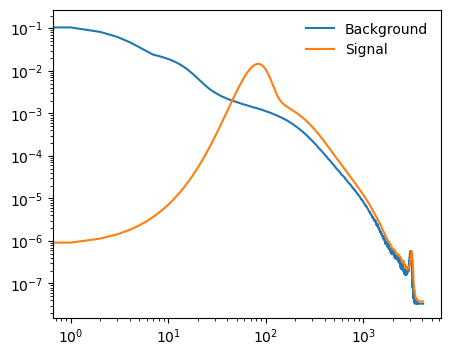

PyObject <matplotlib.legend.Legend object at 0x7fed3697a790>

In [5]:
cv  = cv_2_3

fig, ax = plt.subplots(1,1, figsize=(5,4))

ax.plot(cv[:,1], label="Background")
ax.plot(cv[:,80], label="Signal")

# ax.set_xlim(0.001, 100)
# ax.set_ylim(0.000000001, 0.05)

ax.set_yscale("log")
ax.set_xscale("log")

ax.legend(loc="upper right", ncol=1, framealpha=0.0)

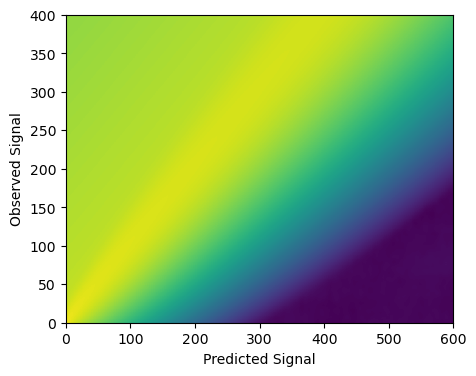

PyObject Text(24.000000000000007, 0.5, 'Observed Signal')

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

# ax.pcolormesh(log.(cv[500:1400, 3500:4000]))
ax.pcolormesh(log.(cv[1:400, 1:600]))

ax.set_xlabel("Predicted Signal")
ax.set_ylabel("Observed Signal")

# Convolution Example: 

In [7]:
# kern = KernelFactors.gaussian((3, 3));

In [8]:
# smeared_cv = imfilter(cv, kern);

In [9]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))

# ax.plot(smeared_cv[:,1], label="Background")
# ax.plot(smeared_cv[:,3060], label="Signal")

# # ax.set_xlim(0.001, 100)
# # ax.set_ylim(0.0000001, 0.05)

# ax.set_yscale("log")
# ax.set_xscale("log")

# ax.legend(loc="upper right", ncol=1, framealpha=0.0)

In [10]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))

# ax.pcolormesh(log.(smeared_cv[500:1400, 3500:4000]))

# ax.set_xlabel("Predicted Signal")
# ax.set_ylabel("Observed Signal")